In [13]:
from ase.io import read
from gGA.data import AtomicData
from gGA.gutz import GhostGutzwiller
from gGA.utils.tools import setup_seed
from gGA.utils.tools import get_semicircle_e_list
import numpy as np
from gGA.data import _keys

setup_seed(123)
U = 5
J = 0.0 * U # 0.25 * U
Up = U - 2*J
Jp = J

alpha = 1.
V = 1.0
ep = -1.0
e_list = get_semicircle_e_list(nmesh=1000)

eks = np.zeros((len(e_list), 2, 2))+0j
eks += np.array([[[0.,  V],
                 [V,   ep]]],dtype=np.complex128)
eks[:,1,1] += alpha * e_list

phy_onsite = {
    "C": np.array([
        [[-U/2, 0.],
        [0., 0.]]
    ]),
}

intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}

gga = GhostGutzwiller(
    atomic_number=np.array([6]),
    nocc=3,
    basis={"C":[1,1]},
    idx_intorb={"C":[0]},
    naux=3,
    intparams=intparams,
    nspin=1,
    kBT=0.0002,
    mutol=1e-6,
    solver="ED",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=True,
    solver_options={}#{"mfepmin":2000, "channels": 10, "Ptol": 1e-5},
)

atomicdata = AtomicData.from_ase(
    read("./gGA/test/C_cube.vasp"),
    r_max=3.1
    )

# atomicdata["kpoint"] = torch.tensor(kmesh_sampling([10,10,10], True)).to(torch.get_default_dtype())
# block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)
atomicdata[_keys.HAMILTONIAN_KEY] = eks
atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite
atomicdata = gga.idp_phy(atomicdata)

In [ ]:
gga.load("./gGA/test/nqs/bethe1o/stateU5P-1P1e-4E6e-4.npz")

True

In [11]:
gga.run(atomicdata, 500, 1e-4)

DM_kin:  [6.18841387e-04 6.18841387e-04 5.06103364e-01 5.06103364e-01
 9.93397453e-01 9.93397453e-01 9.99880590e-01 9.99880590e-01]
 -- Current error: 0.00106
DM_kin:  [6.18854794e-04 6.18854794e-04 5.06086703e-01 5.06086703e-01
 9.93414048e-01 9.93414048e-01 9.99880636e-01 9.99880636e-01]
 -- Current error: 0.00105
DM_kin:  [6.18868082e-04 6.18868082e-04 5.06070130e-01 5.06070130e-01
 9.93430555e-01 9.93430555e-01 9.99880681e-01 9.99880681e-01]
 -- Current error: 0.00105
DM_kin:  [6.18881254e-04 6.18881254e-04 5.06053645e-01 5.06053645e-01
 9.93446974e-01 9.93446974e-01 9.99880726e-01 9.99880726e-01]
 -- Current error: 0.00104
DM_kin:  [6.18894310e-04 6.18894310e-04 5.06037246e-01 5.06037246e-01
 9.93463305e-01 9.93463305e-01 9.99880772e-01 9.99880772e-01]
 -- Current error: 0.00104
DM_kin:  [6.18907253e-04 6.18907253e-04 5.06020933e-01 5.06020933e-01
 9.93479549e-01 9.93479549e-01 9.99880817e-01 9.99880817e-01]
 -- Current error: 0.00103
DM_kin:  [6.18920083e-04 6.18920083e-04 5.0600

{'C': array([[[ 0.15823251+0.j        ,  0.        +0.j        ,
           0.05438328+0.03133144j,  0.        +0.j        ,
          -0.20501626-0.08887606j,  0.        +0.j        ,
           0.        +0.j        ,  0.        +0.j        ],
         [ 0.        +0.j        ,  0.15823251+0.j        ,
           0.        +0.j        ,  0.05438328+0.03133144j,
           0.        +0.j        , -0.20501626-0.08887606j,
           0.        +0.j        ,  0.        +0.j        ],
         [ 0.05438328-0.03133144j,  0.        +0.j        ,
           0.66426622+0.j        ,  0.        +0.j        ,
           0.2895596 -0.033043j  ,  0.        +0.j        ,
           0.        +0.j        ,  0.        +0.j        ],
         [ 0.        +0.j        ,  0.05438328-0.03133144j,
           0.        +0.j        ,  0.66426622+0.j        ,
           0.        +0.j        ,  0.2895596 -0.033043j  ,
           0.        +0.j        ,  0.        +0.j        ],
         [-0.20501626+0.0888760

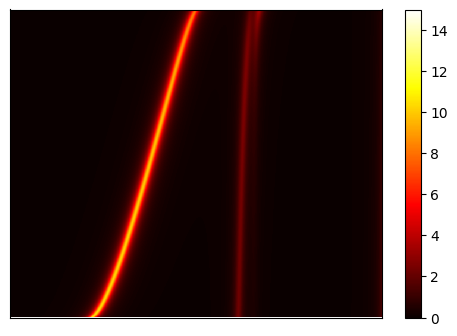

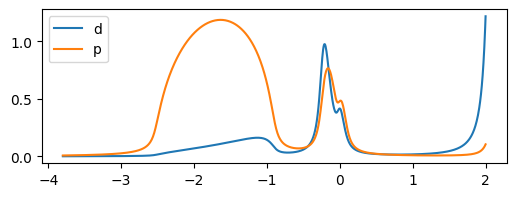

In [15]:
Es = np.linspace(-3.8,2, 1000) + gga.E_fermi
GF = gga.compute_GF(Es=Es, data=atomicdata, eta=0.06)
ARPES = -(1/np.pi)*GF.imag.diagonal(offset=0, axis1=-1, axis2=-2)
pdos = ARPES.sum(0) / ARPES.shape[0]
pdos = pdos.reshape(-1,2,2).sum(-1)
dos = pdos.sum(-1)
ARPES = ARPES.sum(-1)


import matplotlib.pyplot as plt
ARPES = np.flip(ARPES, (0,))
fig, ax = plt.subplots(figsize=(6,4))
m = ax.matshow(ARPES, cmap="hot", vmin=0, vmax=15)
ax.set_aspect('auto')  # override the default 'equal'
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(m)
plt.show()

plt.figure(figsize=(6,2))
# plt.plot(Es, dos)
plt.plot(Es-gga.E_fermi, pdos)
plt.legend(["d", "p"])
plt.show()

# Sweep for metal states

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
records_metal = {}
not_converge_medal = []
for i, ep in tqdm(enumerate([3, 2, 1, 0, -0.5, -1, -2, -3]), desc="Scanning for ep: "):
    gga.reset()
    U_list = [1.,2.,3.,4.,5.,6.,7.,8.]
    for U in tqdm(U_list, desc="Scanning for U: "):
        J = 0.0 * U # 0.25 * U
        Up = U - 2*J
        Jp = J
        alpha = 1.
        V = 1.0

        intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}
        gga.update_intparam(intparams)

        eks = np.zeros((len(e_list), 2, 2))+0j
        eks += np.array([[[0.,  V],
                        [V,   ep]]],dtype=np.complex128)
        eks[:,1,1] += alpha * e_list

        phy_onsite = {
            "C": np.array([
                [[-U/2, 0.],
                [0., 0.]]
            ]),
        }
        atomicdata[_keys.HAMILTONIAN_KEY] = eks
        atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite

        # run
        try:
            gga.run(atomicdata, 1000, 1e-4)
            records_metal[(ep, U)] = (gga.RDM, gga.R, gga.gGAtomic.docc)
        except:
            # gga reset states
            gga.reset()
            try:
                gga.run(atomicdata, 1000, 1e-4)
                records_metal[(ep, U)] = (gga.RDM, gga.R, gga.gGAtomic.docc)
            except:
                gga.reset()
                not_converge_medal.append((ep, U))
            
        clear_output()

np.save("./gGA/test/Bethe1o_metal.npy", records_metal)

Scanning for U: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it]
Scanning for ep: : 8it [14:31, 108.94s/it]


# Sweep for insulator states

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

records_in = {}
not_converge_in = []
for i, ep in tqdm(enumerate([-3, -2, -1, -0.5, 0, 1, 2, 3]), desc="Scanning for ep: "):
    gga.reset()
    U_list = [10.,9.,8.,7.,6.,5.,4.,3.,2.,1.]
    for U in tqdm(U_list, desc="Scanning for U: "):
        J = 0.0 * U # 0.25 * U
        Up = U - 2*J
        Jp = J
        alpha = 1.
        V = 1.0

        intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}
        gga.update_intparam(intparams)

        eks = np.zeros((len(e_list), 2, 2))+0j
        eks += np.array([[[0.,  V],
                        [V,   ep]]],dtype=np.complex128)
        eks[:,1,1] += alpha * e_list

        phy_onsite = {
            "C": np.array([
                [[-U/2, 0.],
                [0., 0.]]
            ]),
        }
        atomicdata[_keys.HAMILTONIAN_KEY] = eks
        atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite

        # run
        try:
            gga.run(atomicdata, 1000, 1e-4)
            records_in[(ep, U)] = (gga.RDM, gga.R, gga.gGAtomic.docc)
        except:
            # gga reset states
            gga.reset()
            try:
                gga.run(atomicdata, 1000, 1e-4)
                records_in[(ep, U)] = (gga.RDM, gga.R, gga.gGAtomic.docc)
            except:
                gga.reset()
                not_converge_in.append((ep, U))
            
        clear_output()

np.save("./gGA/test/Bethe1o_insulator.npy", records_in)

Scanning for U: 100%|██████████| 10/10 [06:22<00:00, 38.23s/it]
Scanning for ep: : 8it [1:29:05, 668.24s/it]


In [1]:
import numpy as np

records_metal = np.load("./gGA/test/Bethe1o_metal.npy", allow_pickle=True).item()
records_in = np.load("./gGA/test/Bethe1o_insulator.npy", allow_pickle=True).item()

In [2]:
docc_m = []
nps_m = []
nds_m = []
eps_m = []
Us_m = []
for ep_, U_ in records_metal:
    RDM, R, docc = records_metal[(ep_,U_)]
    RDM = RDM["C"][0]
    R = R["C"][0]
    docc = docc["C"][0]
    docc_m.append(docc[0])
    nps_m.append(RDM[2,2]+RDM[3,3])
    nds_m.append(RDM[0,0]+RDM[1,1])
    eps_m.append(ep_)
    Us_m.append(U_)
eps_m = np.array(eps_m)
Us_m = np.array(Us_m)
docc_m = np.array(docc_m)
nps_m = np.array(nps_m)
nds_m = np.array(nds_m)

In [3]:
docc_i = []
nps_i = []
nds_i = []
eps_i = []
Us_i = []
for ep_, U_ in records_in:
    RDM, R, docc = records_in[(ep_,U_)]
    RDM = RDM["C"][0]
    R = R["C"][0]
    docc = docc["C"][0]
    docc_i.append(docc[0])
    nps_i.append(RDM[2,2]+RDM[3,3])
    nds_i.append(RDM[0,0]+RDM[1,1])
    eps_i.append(ep_)
    Us_i.append(U_)
eps_i = np.array(eps_i)
Us_i = np.array(Us_i)
docc_i = np.array(docc_i)
nps_i = np.array(nps_i)
nds_i = np.array(nds_i)

# Phase Diagram

In [13]:
eps_i.reshape(-1,10)

array([[-3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. , -3. ],
       [-2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ],
       [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ],
       [ 3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ,  3. ]])

# Line Graph

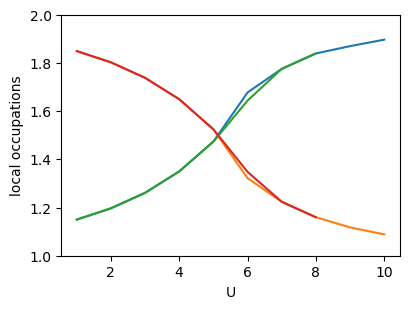

In [4]:
import matplotlib.pyplot as plt


idx = 6
plt.figure(figsize=(4,3))
plt.plot(Us_i.reshape(-1,10)[idx][::-1], nps_i.reshape(-1,10)[idx][::-1])
plt.plot(Us_i.reshape(-1,10)[idx][::-1], nds_i.reshape(-1,10)[idx][::-1])

plt.plot(Us_m.reshape(-1,8)[-idx-1], nps_m.reshape(-1,8)[-idx-1])
plt.plot(Us_m.reshape(-1,8)[-idx-1], nds_m.reshape(-1,8)[-idx-1])


plt.ylim(1.0,2.0)
plt.tight_layout()
plt.xlabel("U")
plt.ylabel("local occupations")
plt.show()

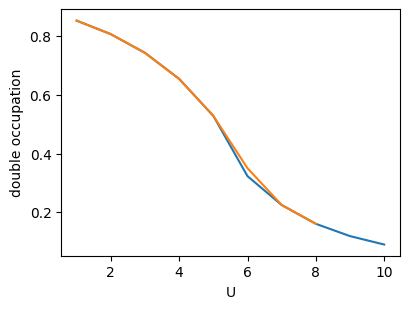

In [48]:
import matplotlib.pyplot as plt


idx = 6
plt.figure(figsize=(4,3))
plt.plot(Us_i.reshape(-1,10)[idx][::-1], docc_i.reshape(-1,10)[idx][::-1])
plt.plot(Us_m.reshape(-1,8)[-idx-1], docc_m.reshape(-1,8)[-idx-1])

# plt.ylim(1.0,2.0)
plt.tight_layout()
plt.xlabel("U")
plt.ylabel("double occupation")
plt.show()

# NQS solver

In [1]:
from ase.io import read
from gGA.data import AtomicData
from gGA.gutz import GhostGutzwiller
from gGA.utils.tools import setup_seed
from gGA.utils.tools import get_semicircle_e_list
import numpy as np
from gGA.data import _keys

setup_seed(124)
U = 1.
J = 0.0 * U # 0.25 * U
Up = U - 2*J
Jp = J

alpha = 1.
V = 1.0
ep = -1.0
e_list = get_semicircle_e_list(nmesh=1000)

eks = np.zeros((len(e_list), 2, 2))+0j
eks += np.array([[[0.,  V],
                 [V,   ep]]],dtype=np.complex128)
eks[:,1,1] += alpha * e_list

phy_onsite = {
    "C": np.array([
        [[-U/2, 0.],
        [0., 0.]]
    ]),
}

intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp, "Szpen":0.2}]}

gga = GhostGutzwiller(
    atomic_number=np.array([6]),
    nocc=3,
    basis={"C":[1,1]},
    idx_intorb={"C":[0]},
    naux=3,
    intparams=intparams,
    nspin=1,
    kBT=0.0002,
    mutol=1e-6,
    solver="NQS",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=False,
    solver_options={
        "mfepmax":800,
        "nnepmax":5000,
        "d_emb": 4,
        "nblocks":3,
        "hidden_channels":8,
        "out_channels":8,
        "ffn_hidden":[8],
        "heads":4,
        "Ptol": 3e-4, # this value should be smaller than at least 5e-4 if expecting 1e-4 convergence
        "Etol": 1e-2
        },
)

atomicdata = AtomicData.from_ase(
    read("./gGA/test/C_cube.vasp"),
    r_max=3.1
    )

# atomicdata["kpoint"] = torch.tensor(kmesh_sampling([10,10,10], True)).to(torch.get_default_dtype())
# block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)
atomicdata[_keys.HAMILTONIAN_KEY] = eks
atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite

The e3nn is not installed, mapper cannot handle irreps related maps, be careful!


The block2 is not installed. One should not use DMRG solver.


/root/Hubbard-AUG/gGA/solver/graph_net.py:179: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  layers = [ReshapeSite(dtype), EmbedLayer(d_emb, dtype), *blocks, eqx.nn.Lambda(lambda x: jnp.swapaxes(x, -1, -2)), scale]


In [2]:
gga.run(atomicdata, 1, 1e-4)

DM_kin:  [0.01250972 0.01250972 0.49864468 0.49864468 0.98885561 0.98885561
 0.99999006 0.99999006]
- - Einf: -0.4070, Ehf: -2.8216


Meanfield Pfaffian training:   0%|          | 0/800 [00:00<?, ?it/s]

Meanfield Pfaffian training:  17%|█▋        | 138/800 [00:14<01:11,  9.26it/s]


KeyboardInterrupt: 

In [3]:
gga.gGAtomic.interact_ansatz[0].singleOrbs[0].solver._Hemb.op_list

[['n',
  [[-0.5, 0],
   [-0.5, 4],
   [0.15034116188725277, 1],
   [0.15034116188725277, 5],
   [-0.505762563149393, 2],
   [-0.505762563149393, 6],
   [0.21849959406335606, 3],
   [0.21849959406335606, 7]]],
 ['+-',
  [[-0.2012044707889061, 0, 1],
   [-0.7367002976269517, 0, 2],
   [-0.610757231543321, 0, 3],
   [-0.2012044707889061, 4, 5],
   [-0.7367002976269517, 4, 6],
   [-0.610757231543321, 4, 7],
   [-0.2012044707889061, 1, 0],
   [-0.21616436011224563, 1, 2],
   [-0.14821080982458842, 1, 3],
   [-0.2012044707889061, 5, 4],
   [-0.21616436011224563, 5, 6],
   [-0.14821080982458842, 5, 7],
   [-0.7367002976269517, 2, 0],
   [-0.21616436011224563, 2, 1],
   [-0.5889251043368802, 2, 3],
   [-0.7367002976269517, 6, 4],
   [-0.21616436011224563, 6, 5],
   [-0.5889251043368802, 6, 7],
   [-0.610757231543321, 3, 0],
   [-0.14821080982458842, 3, 1],
   [-0.5889251043368802, 3, 2],
   [-0.610757231543321, 7, 4],
   [-0.14821080982458842, 7, 5],
   [-0.5889251043368802, 7, 6]]],
 ['nn',
 

In [3]:
import numpy as np

a = np.array([[ 0.32969636-0.j,  0.02696763+0.j,  0.1983875 +0.j,  0.24682143+0.j],
 [ 0.02696763-0.j,  0.98071364-0.j, -0.09681085+0.j,  0.06320421+0.j],
 [ 0.1983875 -0.j, -0.09681085-0.j,  0.50211636-0.j,  0.29353221+0.j],
 [ 0.24682143-0.j,  0.06320421-0.j,  0.29353221-0.j,  0.18747364-0.j]])

b = np.array([[ 0.33896818-0.j,  0.00587948+0.j,  0.21051196+0.j,  0.25225315+0.j],
 [ 0.00587948-0.j,  0.99782273-0.j, -0.01408203+0.j,  0.00214241+0.j],
 [ 0.21051196-0.j, -0.01408203-0.j,  0.47066455-0.j,  0.29941449+0.j],
 [ 0.25225315-0.j,  0.00214241-0.j,  0.29941449-0.j,  0.19254455-0.j]])

c = np.array([[ 2.91895996e-02-0.j, -9.92602790e+01+0.j,  5.14485617e+01+0.j,  7.86423653e+00+0.j],
 [-4.47550544e-02-0.j,  1.35005479e-02-0.j, -4.36086041e-01+0.j, -3.34870824e+00+0.j],
 [ 2.89307691e-02-0.j, -4.92765134e-03-0.j, -2.44934044e-02-0.j, -8.31262689e+00+0.j],
 [ 1.99767819e-02-0.j, -2.09217556e-03-0.j, -1.68526837e-02-0.j, -6.98634789e-03-0.j]])

array([[-0.00927182+0.j,  0.02108815+0.j, -0.01212446+0.j,
        -0.00543172+0.j],
       [ 0.02108815+0.j, -0.01710909+0.j, -0.08272882+0.j,
         0.0610618 +0.j],
       [-0.01212446+0.j, -0.08272882+0.j,  0.03145181+0.j,
        -0.00588228+0.j],
       [-0.00543172+0.j,  0.0610618 +0.j, -0.00588228+0.j,
        -0.00507091+0.j]])